<h2><center> <span style = "font-family: Babas; font-size: 2em;"> E-commerce Text Classification </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em; font-style: italic"> With TF-IDF and Word2Vec </span> </center></h4>


### Importing libraries

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d saurabhshahane/ecommerce-text-classification

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 64% 5.00M/7.86M [00:00<00:00, 42.6MB/s]
100% 7.86M/7.86M [00:00<00:00, 62.1MB/s]


In [ ]:
# File system manangement
import time, psutil, os

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# NLP
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Others
import json
import gensim
from sklearn.decomposition import TruncatedSVD

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=4e4207ae25dffccce26457e844472f127e91a39da43d024669741743ee26803b
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 15.4 MB/s eta 0:00:00


### Runtime and memory usage

In [ ]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

In [ ]:
# Loading and customizing the data
data = pd.read_csv(
    'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/Dataset/ecommerceDataset.csv',
    names = ['label', 'description']
)
data = data[['description', 'label']]

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.77 MB
Dataset shape    (50425, 2)


,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,Household
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
2,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
3,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
4,Incredible Gifts India Wooden Happy Birthday U...,Household
...,...,...
50420,Strontium MicroSD Class 10 8GB Memory Card (Bl...,Electronics
50421,CrossBeats Wave Waterproof Bluetooth Wireless ...,Electronics
50422,Karbonn Titanium Wind W4 (White) Karbonn Titan...,Electronics
50423,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",Electronics


In [ ]:
# Example description
data['description'].iloc[0]

'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal blis

In [ ]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data) - len(data.dropna()),
                 "Number of duplicate observations": data.duplicated().sum()}).to_string())

Number of observations with missing values        1
Number of duplicate observations              22622


In [ ]:
data.dropna(inplace = True) # Dropping observations with missing values
data.drop_duplicates(inplace = True) # Dropping duplicate observations
data.reset_index(drop = True, inplace = True) # Resetting index

The labels are manually encoded with the following scheme:
- **Electronics** $\mapsto$ $0$
- **Household** $\mapsto$ $1$
- **Books** $\mapsto$ $2$
- **Clothing & Accessories** $\mapsto$ $3$

In [ ]:
# Manual encoding of labels
label_dict = {'Electronics': 0, 'Household': 1, 'Books': 2, 'Clothing & Accessories': 3}
data.replace({'label': label_dict}, inplace = True)

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.42 MB
Dataset shape    (27802, 2)


,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,1
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",1
2,SAF 'UV Textured Modern Art Print Framed' Pain...,1
3,"SAF Flower Print Framed Painting (Synthetic, 1...",1
4,Incredible Gifts India Wooden Happy Birthday U...,1
...,...,...
27797,Micromax Bharat 5 Plus Zero impact on visual d...,0
27798,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,0
27799,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",0
27800,Karbonn Titanium Wind W4 (White) Karbonn Titan...,0


## Project Objective

The objective of the project is to classify a product into the four categories `Electronics`, `Household`, `Books` and `Clothing & Accessories`, based on its description available in the e-commerce platform.

# Exploratory Data Analysis

- [**Class Frequencies**](#Class-Frequencies)
- [**Number of Characters**](#Number-of-Characters)
- [**Number of Words**](#Number-of-Words)
- [**Average Word-length**](#Average-Word-length)

We split the dataset based on the target classes, in order to see how different textual attributes vary across classes.

In [ ]:
# Splitting the dataset by label
data_e = data[data['label'] == 0] # Electronics
data_h = data[data['label'] == 1] # Household
data_b = data[data['label'] == 2] # Books
data_c = data[data['label'] == 3] # Clothing & Accessories

## Class Frequencies

In [ ]:
# Visualization of class frequencies
values = np.array([len(data_e), len(data_h), len(data_b), len(data_c)])
labels = ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of class frequencies"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

## Number of Characters

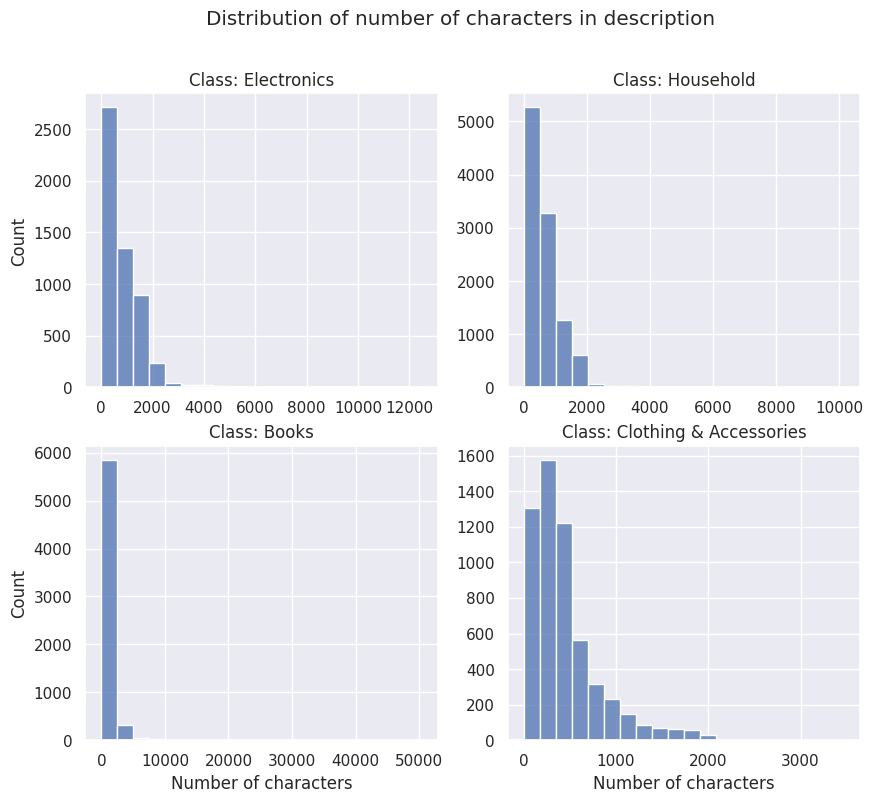

In [ ]:
# Distribution of number of characters in description
data_e_char = data_e['description'].str.len()
data_h_char = data_h['description'].str.len()
data_b_char = data_b['description'].str.len()
data_c_char = data_c['description'].str.len()

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_char, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_char, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_char, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_char, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of characters in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of characters")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

## Number of Words

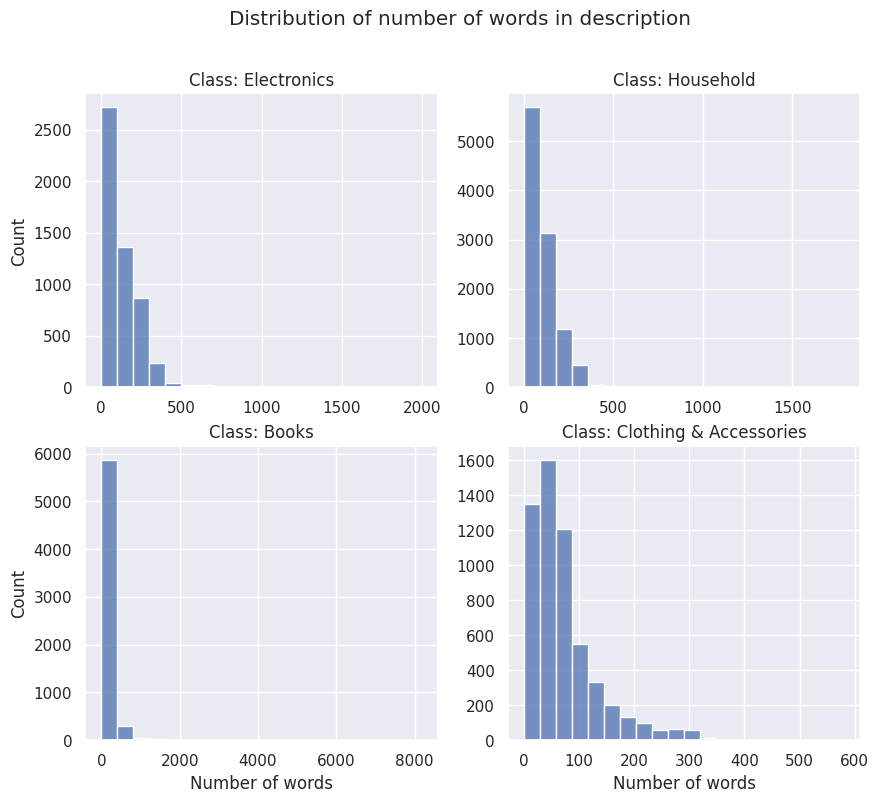

In [ ]:
# Distribution of number of words in description
data_e_word = data_e['description'].str.split().map(lambda x: len(x))
data_h_word = data_h['description'].str.split().map(lambda x: len(x))
data_b_word = data_b['description'].str.split().map(lambda x: len(x))
data_c_word = data_c['description'].str.split().map(lambda x: len(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_word, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_word, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_word, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_word, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of words in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of words")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

## Average Word-length

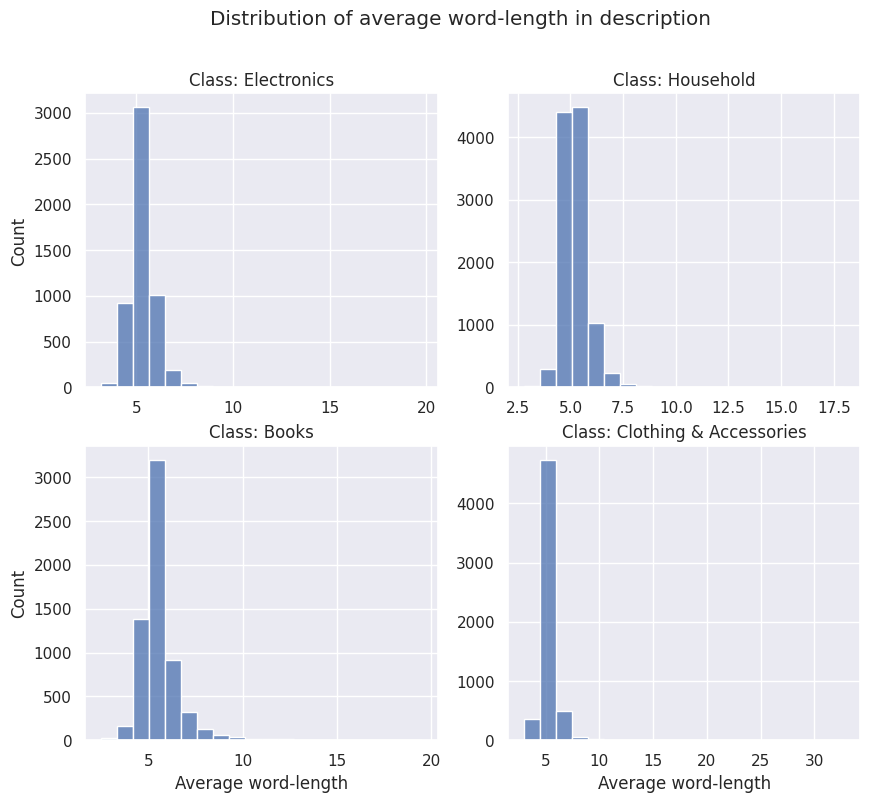

In [ ]:
# Distribution of average word-length in description
data_e_avg = data_e['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_h_avg = data_h['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_b_avg = data_b['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_c_avg = data_c['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_avg, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_avg, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_avg, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_avg, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of average word-length in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Average word-length")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

# Train-Validation-Test Split

In [ ]:
# Feature-target split
X, y = data.drop('label', axis = 1), data['label']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set, validation set and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training set', 'Validation Set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of sizes of training set, validation set and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

# Text Normalization

- [**Convertion to Lowercase**](#Convertion-to-Lowercase)
- [**Removal of Whitespaces**](#Removal-of-Whitespaces)
- [**Removal of Punctuations**](#Removal-of-Punctuations)
- [**Removal of Unicode Characters**](#Removal-of-Unicode-Characters)
- [**Substitution of Acronyms**](#Substitution-of-Acronyms)
- [**Substitution of Contractions**](#Substitution-of-Contractions)
- [**Removal of Stop Words**](#Removal-of-Stop-Words)
- [**Spelling Correction**](#Spelling-Correction)
- [**Stemming and Lemmatization**](#Stemming-and-Lemmatization)
- [**Discardment of Non-alphabetic Words**](#Discardment-of-Non-alphabetic-Words)
- [**Retainment of Relevant Parts of Speech**](#Retainment-of-Relevant-Parts-of-Speech)
- [**Removal of Additional Stop Words**](#Removal-of-Additional-Stop-Words)
- [**Integration of the Processes**](#Integration-of-the-Processes)
- [**Implementation on Product Description**](#Implementation-on-Product-Description)

In natural language processing, **text normalization** is the process of transforming text into a single canonical form. We consider a number of text normalization processes. At the end of the section, we combine selected processes into one single function and apply it on the product descriptions.

In [ ]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

## Convertion to Lowercase

We convert all alphabetical characters of the tweets to lowercase so that the models do not differentiate identical words due to case-sensitivity. For example, without the normalization, *Sun* and *sun* would have been treated as two different words, which is not useful in the present context.

In [ ]:
# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase


## Removal of Whitespaces

We remove the unnecessary empty spaces from the description of the observations.

In [ ]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


## Removal of Punctuations

In [ ]:
# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

text = "Here's [an] example? {of} &a string. with.? punctuations!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))

Input: Here's [an] example? {of} &a string. with.? punctuations!!!!
Output: Here's an example of a string with punctuations


## Removal of Unicode Characters

In [ ]:
# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = '<a href = "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification"> Ecommerce Text Classification </a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))

Input: <a href = "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification"> Ecommerce Text Classification </a>
Output:  Ecommerce Text Classification 


In [ ]:
# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))

Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 


In [ ]:
# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))

Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 


## Substitution of Acronyms

In [ ]:
# Dictionary of acronyms
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict['fyi']))

Example: Original form of the acronym 'fyi' is 'for your information'


In [ ]:
# Dataframe of acronyms
pd.DataFrame(acronyms_dict.items(), columns = ['acronym', 'original']).head()

,acronym,original
0,aka,also known as
1,asap,as soon as possible
2,brb,be right back
3,btw,by the way
4,dob,date of birth


In [ ]:
# List of acronyms
acronyms_list = list(acronyms_dict.keys())

In [ ]:
# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))

Input: btw you've to fill in the details including dob
Output: by the way you've to fill in the details including date of birth


## Substitution of Contractions

In [ ]:
# Dictionary of contractions
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))

Example: Original form of the contraction 'aren't' is 'are not'


In [ ]:
# Dataframe of contractions
pd.DataFrame(contractions_dict.items(), columns = ['contraction', 'original']).head()

,contraction,original
0,'aight,alright
1,ain't,are not
2,amn't,am not
3,arencha,are not you
4,aren't,are not


In [ ]:
# List of contractions
contractions_list = list(contractions_dict.keys())

In [ ]:
# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))

Input: he's doin' fine
Output: he is doing fine


## Removal of Stop Words

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops

print(allstops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

text = "This is a function that removes stopwords in a given text"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))

Input: This is a function that removes stopwords in a given text
Output: This function removes stopwords given text


## Spelling Correction

In [ ]:
# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: I'm goinng therre
Output: I'm going there


## Stemming and Lemmatization

In [ ]:
# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduc lemmat as an improv over stem


In [ ]:
# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


## Discardment of Non-alphabetic Words

In [ ]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is an ocean of thousands and 1000s of crowd
Output: It is an ocean of thousands and of crowd


## Retainment of Relevant Parts of Speech

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

text = "He arrived at seven o'clock on Wednesday evening"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))

Input: He arrived at seven o'clock on Wednesday evening
Tokens: ['He', 'arrived', 'at', 'seven', "o'clock", 'on', 'Wednesday', 'evening']
Tagged Tokens: [('He', 'PRP'), ('arrived', 'VBD'), ('at', 'IN'), ('seven', 'CD'), ("o'clock", 'NN'), ('on', 'IN'), ('Wednesday', 'NNP'), ('evening', 'NN')]
Output: He arrived o'clock Wednesday evening


## Removal of Additional Stop Words

In [ ]:
# Additional stopwords

alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

## Integration of the Processes

In [ ]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
#     text = pyspellchecker(text)
    text = text_lemmatizer(text) # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: combine function function apply product description


## Implementation on Product Description

In [ ]:
%%time
# Implementing text normalization
data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

data_train_norm['normalized description'] = data_train['description'].apply(text_normalizer)
data_val_norm['normalized description'] = data_val['description'].apply(text_normalizer)
data_test_norm['normalized description'] = data_test['description'].apply(text_normalizer)

data_train_norm['label'] = data_train['label']
data_val_norm['label'] = data_val['label']
data_test_norm['label'] = data_test['label']

data_train_norm

CPU times: user 6min 38s, sys: 2.16 s, total: 6min 40s
Wall time: 7min 34s


,normalized description,label
15525,approach acupuncture author author graduate al...,2
1536,nice leatherette office arm chair chair seat h...,1
21984,ekan fedora hat girl boy fedora hat hat man fe...,3
25056,concert showlightning controller lighting cont...,0
25213,marantz fully beltdrive premounted cartridge b...,0
...,...,...
23992,apple tablet inch gb wifi gold matter task pro...,0
27640,skin sticker super hero collection fit dell hp...,0
14501,challenger sale take control customer conversa...,2
14555,mathematics work book opinion class,2


## Text Vectorization

In [ ]:
# Features and labels
X_train_norm, y_train = data_train_norm['normalized description'].tolist(), data_train_norm['label'].tolist()
X_val_norm, y_val = data_val_norm['normalized description'].tolist(), data_val_norm['label'].tolist()
X_test_norm, y_test = data_test_norm['normalized description'].tolist(), data_test_norm['label'].tolist()

In [ ]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
X_val_tfidf = TfidfVec.transform(X_val_norm)
X_test_tfidf = TfidfVec.transform(X_test_norm)

## TF-IDF Baseline Modeling

In [ ]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier()
]

In [ ]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [ ]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
6,Ridge Classifier,0.983634,0.953957
3,Linear SVM,0.978193,0.952518
5,SGD Classifier,0.967807,0.952158
0,Logistic Regression,0.966818,0.943525
4,Random Forest,0.999910,0.928777
7,XGBoost,0.962592,0.922662
1,KNN Classifier,0.916101,0.905396
2,Decision Tree,0.999955,0.861511
8,AdaBoost,0.809541,0.786331


## TF-IDF Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for linear SVM
svm_classifier = svm.SVC()
params_svm = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100]
}

best_model_svm, best_params_svm, best_score_svm, count = svm_classifier, ParameterGrid(params_svm)[0], 0, 0
for g in ParameterGrid(params_svm):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    svm_classifier.set_params(**g)
    svm_classifier.fit(X_train_tfidf, y_train)
    y_train_pred, y_val_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_svm:
        best_params_svm, best_score_svm = g, score_val

best_model_tfidf, best_params_tfidf, best_score_tfidf = svm.SVC(), best_params_svm, best_score_svm
best_model_tfidf.set_params(**best_params_tfidf)
print(f"Best model: {best_model_tfidf}")
print(" ")
print(f"Best parameters: {best_params_tfidf}")
print(f"Best validation accuracy: {best_score_tfidf}")

<ipython-input-48-90b86ac05a54>:8: DeprecationWarning:

`product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.



Gridpoint #1: {'C': 0.1, 'kernel': 'linear'}
Training accuracy: 0.9358841778697001, Validation accuracy: 0.9241007194244605, Runtime: 2m52s
 
Gridpoint #2: {'C': 1, 'kernel': 'linear'}
Training accuracy: 0.9781934265545614, Validation accuracy: 0.9525179856115108, Runtime: 1m49s
 
Gridpoint #3: {'C': 10, 'kernel': 'linear'}
Training accuracy: 0.9981115957016321, Validation accuracy: 0.9464028776978417, Runtime: 1m55s
 
Gridpoint #4: {'C': 100, 'kernel': 'linear'}
Training accuracy: 0.999370531900544, Validation accuracy: 0.9377697841726619, Runtime: 1m50s
 
Best model: SVC(C=1, kernel='linear')
 
Best parameters: {'C': 1, 'kernel': 'linear'}
Best validation accuracy: 0.9525179856115108


# Word2Vec Model

## Partial Text Normalization

In [ ]:
# Relevant text normalization processes
def convert_to_lowercase(text): return text.lower()

contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    return " ".join(words)

In [ ]:
# Text normalization for Word2Vec
for df in [data_train, data_val, data_test]:
    df['tokens'] = (df["description"].apply(convert_to_lowercase)
                                     .apply(convert_contractions)
                                     .apply(regexp.tokenize))
data_train[['tokens', 'label']]

,tokens,label
15525,"[practical, approach, to, acupuncture, 1, abou...",2
1536,"[nice, goods, leatherette, office, arm, chair,...",1
21984,"[ekan, fashionable, fedora, hat, for, girls, b...",3
25056,"[techyshop, dmx512, professional, concert, sho...",0
25213,"[marantz, tt5005, fully, automatic, belt, driv...",0
...,...,...
23992,"[apple, ipad, pro, mpf12hn, a, tablet, 10, 5, ...",0
27640,"[printelligent, laptop, skins, stickers, super...",0
14501,"[the, challenger, sale, taking, control, of, t...",2
14555,"[international, mathematics, olympiad, work, b...",2


## Word Embedding

In [ ]:
!kaggle datasets download -d sugataghosh/google-word2vec

Dataset URL: https://www.kaggle.com/datasets/sugataghosh/google-word2vec
License(s): other
 99% 1.63G/1.64G [00:22<00:00, 180MB/s]
100% 1.64G/1.64G [00:22<00:00, 77.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/google-word2vec.zip', 'r')
zip_ref.extractall('/content')

In [ ]:
# Loading the pre-trained Word2Vec model
word2vec_path = '/content/GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

In [ ]:
# Some useful functions for Word2Vec
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2)
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ['red', 'blue', 'green', 'black']

    plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color = 'red', label = 'Electronics')
    blue_patch = mpatches.Patch(color = 'blue', label = 'Household')
    green_patch = mpatches.Patch(color = 'green', label = 'Books')
    black_patch = mpatches.Patch(color = 'black', label = 'Clothing & Accessories')
    plt.legend(handles = [red_patch, blue_patch, green_patch, black_patch], prop = {"size": 12})

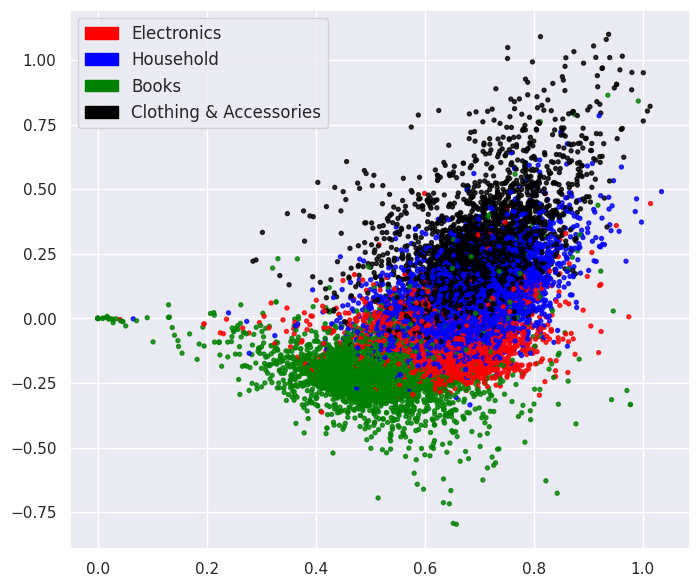

In [ ]:
# Word2Vec embedding
X_train_embed = get_word2vec_embeddings(word2vec, data_train['tokens'])
X_val_embed = get_word2vec_embeddings(word2vec, data_val['tokens'])
X_test_embed = get_word2vec_embeddings(word2vec, data_test['tokens'])

fig = plt.figure(figsize = (8, 7))
plot_embedding(X_train_embed, y_train)
plt.show()

In [ ]:
# Converting to Compressed Sparse Row matrix
X_train_w2v = scipy.sparse.csr_matrix(X_train_embed)
X_val_w2v = scipy.sparse.csr_matrix(X_val_embed)
X_test_w2v = scipy.sparse.csr_matrix(X_test_embed)

## Word2Vec Baseline Modeling

In [ ]:
# Summary of baseline models
score(X_train_w2v, y_train, X_val_w2v, y_val, names = names, models = models)

## Word2Vec Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for XGBoost
xgb = XGBClassifier()
params_xgb = {
    'learning_rate': [0.03, 0.3],
    'min_child_weight': [0, 10],
    'n_estimators': [200],
    'reg_lambda': [1, 2],
    'seed': [40]
}

best_model_xgb, best_params_xgb, best_score_xgb, count = xgb, ParameterGrid(params_xgb)[0], 0, 0
for g in ParameterGrid(params_xgb):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    xgb.set_params(**g)
    xgb.fit(X_train_w2v, y_train)
    y_train_pred, y_val_pred = xgb.predict(X_train_w2v), xgb.predict(X_val_w2v)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_xgb:
        best_params_xgb, best_score_xgb = g, score_val

best_model_w2v, best_params_w2v, best_score_w2v = XGBClassifier(), best_params_xgb, best_score_xgb
best_model_w2v.set_params(**best_params_w2v)
print(f"Best model: {best_model_w2v}")
print(" ")
print(f"Best parameters: {best_params_w2v}")
print(f"Best validation accuracy: {best_score_w2v}")

# Final Prediction and Evaluation

In [ ]:
# Function to compute and print confusion matrix
def conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16):
    class_names = [0, 1, 2, 3] # ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(4), range(4))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

In [ ]:
# Best model
if best_score_tfidf >= best_score_w2v:
    best_model, X_train_vec, X_test_vec = best_model_tfidf, X_train_tfidf, X_test_tfidf
else:
    best_model, X_train_vec, X_test_vec = best_model_w2v, X_train_w2v, X_test_w2v

In [ ]:
# Prediction and evaluation on test set
best_model.fit(X_train_vec, y_train)
y_test_pred = best_model.predict(X_test_vec)
score_test = accuracy_score(y_test, y_test_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16) # Confusion matrix

In [ ]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())